In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import numpy as np

# Tiền xử lí dữ liệu
- Loại dữ liệu từ csv
- is null
- duplicate
- outlier

In [131]:
estate_data = pd.read_csv('data/vietnam_housing_dataset.csv')

In [132]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


In [133]:
estate_data = estate_data.drop(['Balcony direction', 'House direction', 'Furniture state', 'Access Road', 'Address'], axis=1)

In [134]:
estate_data['Frontage_missing'] = estate_data['Frontage'].isna().astype(int)
median_frontage = estate_data['Frontage'].median()
estate_data['Frontage'] = estate_data['Frontage'].fillna(median_frontage)

estate_data['Floors'] = estate_data['Floors'].fillna(estate_data['Floors'].median())

estate_data['Bedrooms'] = estate_data['Bedrooms'].fillna(estate_data['Bedrooms'].median())

estate_data['Bathrooms'] = estate_data['Bathrooms'].fillna(estate_data['Bathrooms'].median())

estate_data['Legal status'] = estate_data['Legal status'].fillna('Unknown')

In [135]:
estate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,30229.0,68.498741,48.069835,3.1,40.0,56.0,80.0,595.0
Frontage,30229.0,5.032055,3.440693,1.0,4.0,4.5,5.0,77.0
Floors,30229.0,3.361507,1.254256,1.0,2.0,3.0,4.0,10.0
Bedrooms,30229.0,3.423765,1.207520,1.0,3.0,3.0,4.0,9.0
Bathrooms,30229.0,3.265672,1.234208,1.0,3.0,3.0,4.0,9.0
Price,30229.0,5.872078,2.211877,1.0,4.2,5.9,7.5,11.5
Frontage_missing,30229.0,0.382547,0.486017,0.0,0.0,0.0,1.0,1.0


In [136]:
estate_data.describe(exclude='number').T

,count,unique,top,freq
Legal status,30229,3,Have certificate,24774


In [137]:
cap_area = estate_data['Area'].quantile(0.95)
estate_data['Area'] = estate_data['Area'].clip(upper=cap_area)

In [138]:
cap_frontage = estate_data['Frontage'].quantile(0.95)
estate_data['Frontage'] = estate_data['Frontage'].clip(upper=cap_frontage)

In [139]:
estate_data.duplicated()
estate_data = estate_data.drop_duplicates()
estate_data.shape

(28394, 8)

In [ ]:
legal_dummies = pd.get_dummies(estate_data['Legal status'], prefix='legal', drop_first=True)

,legal_Sale contract,legal_Unknown
0,False,False
1,False,True
2,True,False
3,False,False
4,False,False
...,...,...
30223,False,True
30224,False,False
30226,False,False
30227,False,True


In [118]:
estate_data['log_area'] = np.log(estate_data['Area'])

estate_data['log_price'] = np.log(estate_data['Price'])

# Phân tích mối quan hệ của các thuộc tính
- heatmap
- biểu đồ (cột/đường/top) -> sau mỗi biểu đồ cần 1 kết luận

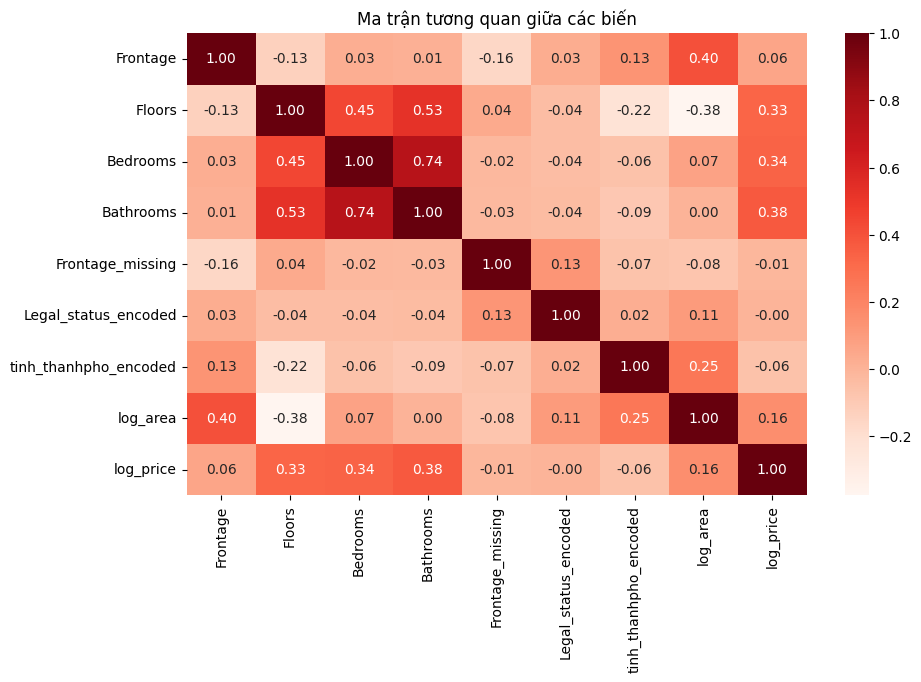

In [120]:
correlations_df = estate_data.drop(['Area', 'Price', 'Legal status', 'tinh_thanhpho'], axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(correlations_df.corr(), annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.title("Ma trận tương quan giữa các biến")
plt.show()

Text(0.5, 1.0, 'Distribution of bathroom counts')

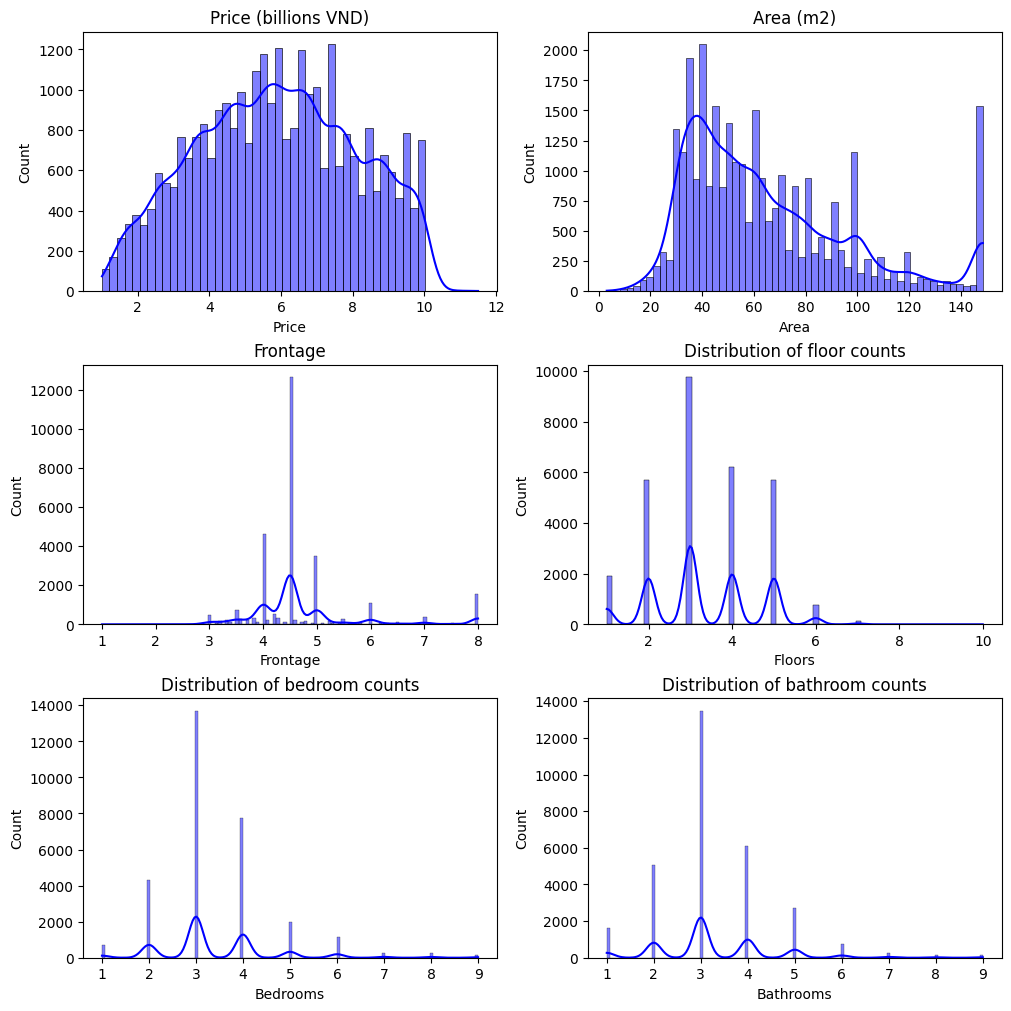

In [81]:
his_fig, his_axis = plt.subplots(3, 2, figsize=(10, 10), layout="constrained")
plt.title("Distribution") #histogram for numerical data

sns.histplot(data=estate_data, x=estate_data['Price'], kde=True, color='blue', ax=his_axis[0,0]).set_title("Price (billions VND)")
sns.histplot(data=estate_data, x=estate_data['Area'], kde=True, color='blue', ax=his_axis[0,1]).set_title("Area (m2)")
sns.histplot(data=estate_data, x=estate_data['Frontage'], kde=True, color='blue', ax=his_axis[1,0]).set_title("Frontage")
sns.histplot(data=estate_data, x=estate_data['Floors'], kde=True, color='blue', ax=his_axis[1,1]).set_title("Distribution of floor counts")
sns.histplot(data=estate_data, x=estate_data['Bedrooms'], kde=True, color='blue', ax=his_axis[2,0]).set_title("Distribution of bedroom counts")
sns.histplot(data=estate_data, x=estate_data['Bathrooms'], kde=True, color='blue', ax=his_axis[2,1]).set_title("Distribution of bathroom counts")


In [82]:
top5_province_index = estate_data["tinh_thanhpho"].value_counts().iloc[:5].index.to_list()
other_count = estate_data["tinh_thanhpho"].value_counts().iloc[5:].sum()
plot_category = top5_province_index+['Tỉnh_TP khác']

plot_df = pd.DataFrame({'Tỉnh_TP': plot_category, 'Count': estate_data["tinh_thanhpho"].value_counts().nlargest(5).tolist() + [other_count]})

Text(0.5, 1.0, 'Province')

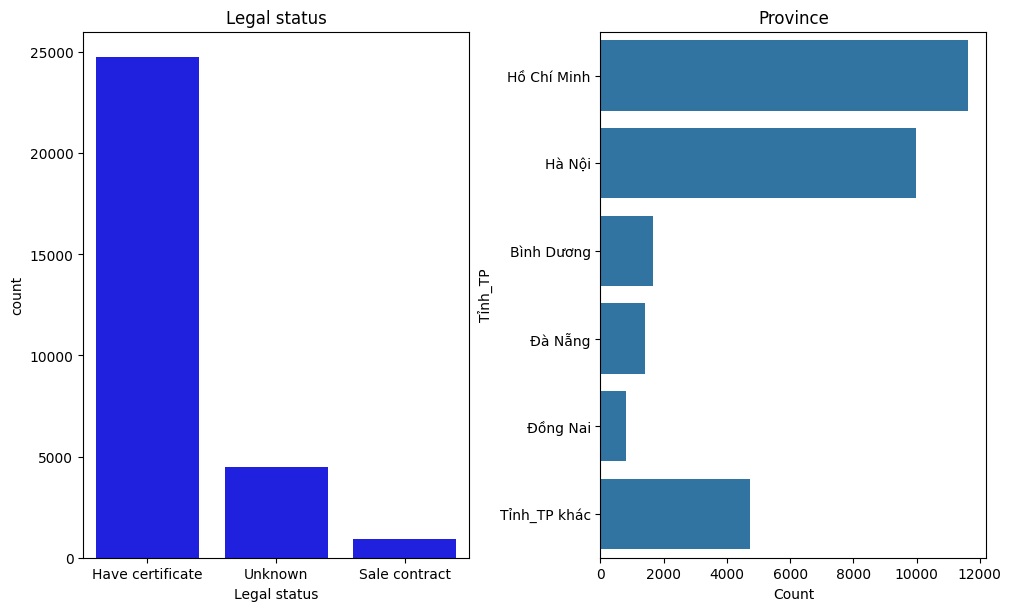

In [83]:
count_fig, count_axis = plt.subplots(1, 2, figsize=(10, 6), layout="constrained")
plt.title("Distribution")

sns.countplot(data=estate_data, x=estate_data['Legal status'], ax=count_axis[0], color='blue').set_title("Legal status")
sns.barplot(x='Count', y='Tỉnh_TP', data=plot_df, order=plot_category, ax=count_axis[1], legend=False).set_title("Province")

In [84]:
features = list(estate_data.select_dtypes(include='number').columns)

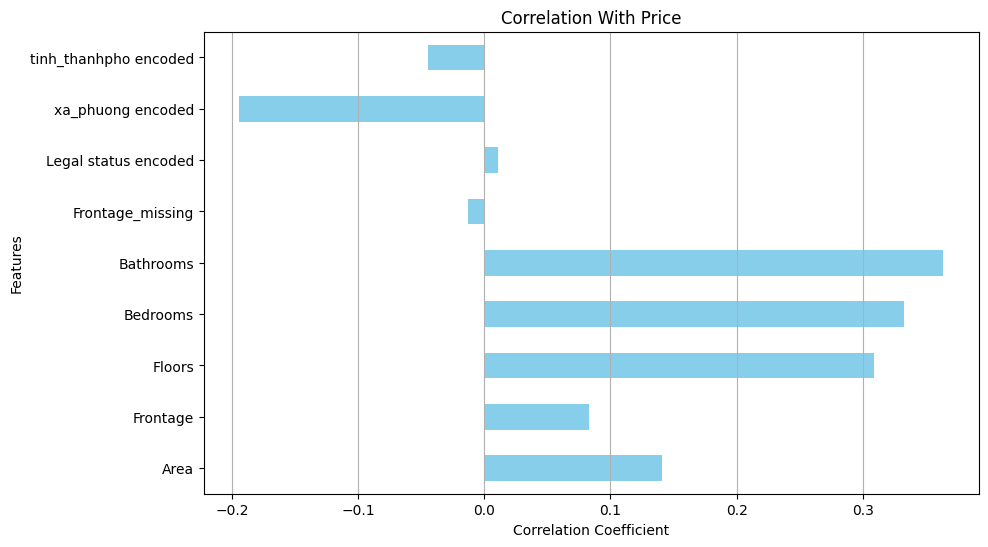

In [85]:
correlations = estate_data[features].corr()['Price'].drop(['Price'])

plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlation With Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

# Train - test - prediction
- Tạo mô hình
- Chia tập train - test
- Train (fit)
- Đánh giá mô hình với R^2 + MSE với tập test
- Dự đoán (có thể vẽ mô hình)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X = estate_data.drop(columns=['tinh_thanhpho', 'xa_phuong', 'Legal status', 'Price', 'Area'], axis=1)
y = estate_data['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize model
model = LinearRegression()


In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model's performance
def evaluate_performance(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print('Mean Absolute Error: ', mae)
    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', rmse)
    print('R2 Score: ', r2)

    
evaluate_performance(y_test, y_pred)

Mean Absolute Error:  1.5397423529004346
Mean Squared Error:  3.614195271546145
Root Mean Squared Error:  1.9011036982621818
R2 Score:  0.258765427710252


In [88]:
model.intercept_
model.coef_

array([ 0.02120701,  0.04567918,  0.57581703,  0.1509471 ,  0.21461013,
       -0.01031297,  0.03128813, -0.00172851, -0.00549906])